# Emotion Detection from Keyboard Typing Patterns

End-to-end pipeline: load data → feature engineering → model training → evaluation → export artifacts.

**Files**:
- `synthetic_session_level.csv` (demo data)
- `data_template.csv` (record-by-key events template)

You can replace the synthetic data with your real aggregated session-level features.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

base = Path('.')
df = pd.read_csv(base / 'synthetic_session_level.csv')
df.head()

,session_id,user_id,n_keys,wpm,dwell_mean_ms,dwell_std_ms,flight_mean_ms,flight_std_ms,dwell_cv,flight_cv,digraph_var,iqr_delay_ms,burstiness,pauses_over_500ms,backspace_rate,self_report_valence_1to9,self_report_arousal_1to9,label_emotion
0,S540729,U30,201,1394.488192,94.537333,17.668215,120.595360,35.261051,0.186891,0.292391,245.841116,46.671675,5.576393,0.0,0.049751,8,7,happy
1,S579165,U29,416,1395.829813,94.308146,19.976624,120.617770,35.268584,0.211823,0.292400,288.481221,46.427268,6.010986,0.0,0.052885,7,5,happy
2,S163209,U29,416,1391.409924,93.249867,19.292602,122.358772,36.188314,0.206891,0.295756,287.920524,48.301510,4.891197,0.0,0.052885,7,5,happy
3,S874987,U30,193,1395.527764,95.755208,18.898071,119.217226,34.646019,0.197358,0.290613,345.053154,42.789383,5.093063,0.0,0.046632,6,5,happy
4,S516741,U24,363,1402.253115,93.570174,19.737551,120.371229,34.602448,0.210938,0.287464,204.942086,43.140898,6.899826,0.0,0.041322,6,6,happy


## Train/test split & feature selection

In [2]:
target = 'label_emotion'
feature_cols = [c for c in df.columns if c not in ['session_id', 'user_id', target]]
X = df[feature_cols]
y = df[target]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
X_train.shape, X_test.shape

((180, 15), (60, 15))

## Baseline: RandomForest

Train Acc: 1.0
Test Acc: 1.0

Classification Report (Test):
               precision    recall  f1-score   support

        calm       1.00      1.00      1.00        15
       happy       1.00      1.00      1.00        15
         sad       1.00      1.00      1.00        15
    stressed       1.00      1.00      1.00        15

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



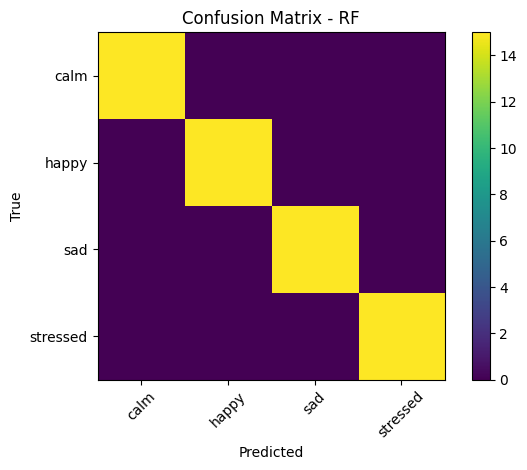

In [3]:
rf = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42)
rf.fit(X_train, y_train)
print('Train Acc:', rf.score(X_train, y_train))
print('Test Acc:', rf.score(X_test, y_test))
print('\nClassification Report (Test):\n', classification_report(y_test, rf.predict(X_test)))
cm = confusion_matrix(y_test, rf.predict(X_test), labels=sorted(y.unique()))
fig = plt.figure()
plt.imshow(cm)
plt.title('Confusion Matrix - RF')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(range(len(sorted(y.unique()))), sorted(y.unique()), rotation=45)
plt.yticks(range(len(sorted(y.unique()))), sorted(y.unique()))
plt.colorbar()
plt.tight_layout()
plt.show()

## Neural Baseline: MLPClassifier

Train Acc: 1.0
Test Acc: 1.0

Classification Report (Test):
               precision    recall  f1-score   support

        calm       1.00      1.00      1.00        15
       happy       1.00      1.00      1.00        15
         sad       1.00      1.00      1.00        15
    stressed       1.00      1.00      1.00        15

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



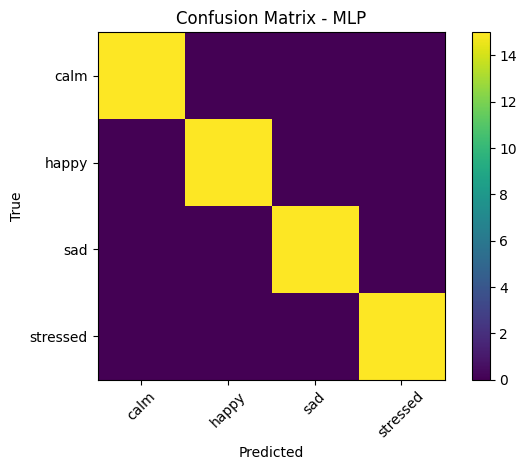

In [4]:
mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42))
])
mlp.fit(X_train, y_train)
print('Train Acc:', mlp.score(X_train, y_train))
print('Test Acc:', mlp.score(X_test, y_test))
print('\nClassification Report (Test):\n', classification_report(y_test, mlp.predict(X_test)))
cm = confusion_matrix(y_test, mlp.predict(X_test), labels=sorted(y.unique()))
fig = plt.figure()
plt.imshow(cm)
plt.title('Confusion Matrix - MLP')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(range(len(sorted(y.unique()))), sorted(y.unique()), rotation=45)
plt.yticks(range(len(sorted(y.unique()))), sorted(y.unique()))
plt.colorbar()
plt.tight_layout()
plt.show()

## Export trained model (optional)
You can persist the trained model with joblib for deployment.

In [5]:
import joblib
joblib.dump(rf, 'rf_model.joblib')
joblib.dump(mlp, 'mlp_pipeline.joblib')
print('Saved rf_model.joblib and mlp_pipeline.joblib')

Saved rf_model.joblib and mlp_pipeline.joblib


## Notes on Ethics, Privacy & Limitations
- Always collect informed consent and allow opt-out.
- Store only derived features (not raw text), and anonymize user IDs.
- Emotions are subjective; treat outputs as *assistive* signals, not diagnoses.
- Expect distribution shift across devices, languages, and contexts; validate before deployment.